## Computer Vision for Object Detection in Retail



In [51]:
# preload needed libraries 

import wallaroo
from wallaroo.object import EntityNotFoundError
from wallaroo.framework import Framework
from IPython.display import display
from IPython.display import Image
import pandas as pd
import json
import datetime
import time
import cv2
import matplotlib.pyplot as plt
import string
import random
import pyarrow as pa
import sys
import asyncio
import numpy as np


import utils
pd.set_option('display.max_colwidth', None)

## Deploying a Mobilenet Pipeline using Wallaroo

In [53]:
wl = wallaroo.Client(request_timeout=600)

wl = wallaroo.Client()

wallarooPrefix = "doc-test."
wallarooSuffix = "wallaroocommunity.ninja"

wl = wallaroo.Client(api_endpoint=f"https://{wallarooPrefix}api.{wallarooSuffix}", 
                    auth_endpoint=f"https://{wallarooPrefix}keycloak.{wallarooSuffix}", 
                    auth_type="sso",
                    request_timeout=600)

First, we authenticate and connect to our Wallaroo cluster and workspace

In [54]:
workspace = utils.getWorkspace(wl, "cv-retail-edge-reactor")
_ = wl.set_current_workspace(workspace)

Then, we upload our model to the cluster:

In [55]:
input_schema = pa.schema([
    pa.field('tensor', pa.list_(
        pa.list_(
            pa.list_(
                pa.float32(), # images are normalized
                list_size=640
            ),
            list_size=480
        ),
        list_size=3
    )),
])

output_schema = pa.schema([
    pa.field('boxes', pa.list_(pa.list_(pa.float32(), list_size=4))),
    pa.field('classes', pa.list_(pa.int64())),
    pa.field('confidences', pa.list_(pa.float32())),
    pa.field('avg_px_intensity', pa.list_(pa.float32())),
    pa.field('avg_confidence', pa.list_(pa.float32())),
])

model_name = "resnet-with-intensity"
model = wl.upload_model(model_name, "./models/model-with-pixel-intensity.zip", 
                        framework=Framework.CUSTOM,
                        input_schema=input_schema, 
                        output_schema=output_schema)

Waiting for model loading - this will take up to 10.0min.
Model is pending loading to a container runtime.....
Model is attempting loading to a container runtime.............successful

Ready


Next, we configure the hardware we want to use for deployment. If we plan on eventually deploying to edge, this is a good way to simulate edge hardware condiditons:

Now we can construct our pipeline object around the model and deploy:

## Monitoring for Model Drift

For this example, we want to track the average confidence of object predictions and get alerted if we see a drop in confidence. To accomplish this, we'll add a simple Python step that computes the average confidence to our pipeline:

In [57]:
deployment_config = wallaroo.DeploymentConfigBuilder() \
    .replica_count(1) \
    .cpus(1) \
    .memory("2Gi") \
    .sidekick_cpus(model, 1) \
    .sidekick_memory(model, '6Gi') \
    .build()

In [58]:

# assuming the steps already added in from the other notebook

pipeline_name = 'retail-inv-tracker-edge-obs'
pipeline = wl.build_pipeline(pipeline_name)
pipeline.clear()
pipeline.add_model_step(model)
pipeline.deploy(deployment_config = deployment_config)

name,retail-inv-tracker-edge-obs
created,2024-01-08 18:38:42.874282+00:00
last_updated,2024-01-08 18:38:43.587022+00:00
deployed,True
arch,None
tags,
versions,"655dd997-120c-4fc0-a780-0b8a332c6fcb, e89a34a8-85b7-47d7-b1c2-3371c8bc73b4"
steps,resnet-with-intensity
published,False


In [59]:
pipeline.status()

{'status': 'Running',
 'details': [],
 'engines': [{'ip': '10.244.0.9',
   'name': 'engine-7f8744889c-45v8p',
   'status': 'Running',
   'reason': None,
   'details': [],
   'pipeline_statuses': {'pipelines': [{'id': 'retail-inv-tracker-edge-obs',
      'status': 'Running'}]},
   'model_statuses': {'models': [{'name': 'resnet-with-intensity',
      'version': 'da95a2c7-cdc4-40a8-9667-c61c0a1dd895',
      'sha': '6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0',
      'status': 'Running'}]}}],
 'engine_lbs': [{'ip': '10.244.2.5',
   'name': 'engine-lb-584f54c899-p7kh4',
   'status': 'Running',
   'reason': None,
   'details': []}],
 'sidekicks': [{'ip': '10.244.0.8',
   'name': 'engine-sidekick-resnet-with-intensity-1-5fc886476-xb87m',
   'status': 'Running',
   'reason': None,
   'details': [],
   'statuses': '\n'}]}

In [60]:
baseline_images = [
    "./data/images/input/example/dairy_bottles.png",
    "./data/images/input/example/dairy_products.png",
    "./data/images/input/example/product_cheeses.png"
]
   
blurred_images = [
    "./data/images/input/example/blurred-dairy_bottles.png",
    "./data/images/input/example/blurred-dairy_products.png",
    "./data/images/input/example/blurred-product_cheeses.png"
]

baseline_images_list = utils.processImages(baseline_images)
blurred_images_list = utils.processImages(blurred_images)


In [61]:
df_test = pd.DataFrame({'tensor': wallaroo.utils.flatten_np_array_columns(baseline_images_list[0], 'tensor')})

In [62]:
df_test

,tensor
0,"[0.9372549, 0.9529412, 0.9490196, 0.94509804, 0.94509804, 0.94509804, 0.94509804, 0.94509804, 0.94509804, 0.94509804, 0.94509804, 0.94509804, 0.94509804, 0.94509804, 0.94509804, 0.94509804, 0.94509804, 0.94509804, 0.9490196, 0.9490196, 0.9529412, 0.9529412, 0.9490196, 0.9607843, 0.96862745, 0.9647059, 0.96862745, 0.9647059, 0.95686275, 0.9607843, 0.9647059, 0.9647059, 0.9607843, 0.9647059, 0.972549, 0.95686275, 0.9607843, 0.91764706, 0.95686275, 0.91764706, 0.8784314, 0.89411765, 0.84313726, 0.8784314, 0.8627451, 0.8509804, 0.9254902, 0.84705883, 0.96862745, 0.89411765, 0.81960785, 0.8509804, 0.92941177, 0.8666667, 0.8784314, 0.8666667, 0.9647059, 0.9764706, 0.98039216, 0.9764706, 0.972549, 0.972549, 0.972549, 0.972549, 0.972549, 0.972549, 0.98039216, 0.89411765, 0.48235294, 0.4627451, 0.43137255, 0.27058825, 0.25882354, 0.29411766, 0.34509805, 0.36862746, 0.4117647, 0.45490196, 0.4862745, 0.5254902, 0.56078434, 0.6039216, 0.64705884, 0.6862745, 0.72156864, 0.74509805, 0.7490196, 0.7882353, 0.8666667, 0.98039216, 0.9882353, 0.96862745, 0.9647059, 0.96862745, 0.972549, 0.9647059, 0.9607843, 0.9607843, 0.9607843, 0.9607843, ...]"


In [83]:
result = pipeline.infer(df_test, dataset=['time', 'out.avg_confidence','out.avg_px_intensity','out.boxes','out.classes','out.confidences','check_failures','metadata'])
result

time out.avg_confidence out.avg_px_intensity  \
0 2024-01-08 18:57:22.041       [0.35880384]           [0.425382]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

In [84]:
ops_partition = result.loc[0, 'metadata.partition']
ops_partition

'engine-7f8744889c-45v8p'

In [219]:
# example of an inference from a bad photo

df_test = pd.DataFrame({'tensor': wallaroo.utils.flatten_np_array_columns(blurred_images_list[0], 'tensor')})

In [220]:
result = pipeline.infer(df_test, dataset=['time', 'out.avg_confidence','out.avg_px_intensity','out.boxes','out.classes','out.confidences','check_failures','metadata'])
result

,time,out.avg_confidence,out.avg_px_intensity,out.boxes,out.classes,out.confidences,check_failures,metadata.dropped,metadata.elapsed,metadata.last_model,metadata.partition,metadata.pipeline_version
0,2024-01-08 22:27:31.727,[0.29440108],[0.42540666],"[[1.104647, 203.48311, 81.29011, 472.4321], [67.34002, 195.64558, 163.41652, 470.1668], [218.88916, 180.21216, 281.3725, 422.2332], [156.47955, 189.82559, 227.1866, 443.35718], [393.81195, 172.34473, 434.30322, 363.96057], [266.56137, 201.46182, 326.2503, 406.3162], [542.941, 99.440956, 588.42365, 229.33481], [426.12668, 260.50723, 638.6193, 476.10742], [511.26102, 106.84715, 546.8103, 243.0127], [0.0, 68.56848, 482.48538, 472.53766], [347.34027, 0.0, 401.10968, 97.51968], [289.03827, 0.32189485, 347.78888, 93.458755], [91.05826, 183.34473, 207.86084, 469.46518], [613.1202, 102.11072, 639.4794, 228.7474], [369.04257, 177.80518, 419.34775, 371.53873], [512.19727, 92.89032, 548.08636, 239.37686], [458.50125, 115.80958, 485.57538, 236.75961], [571.35834, 102.115395, 620.06, 230.47636], [481.23752, 105.288246, 516.5597, 246.37486], [74.288246, 0.4324219, 162.55719, 80.09118], [566.6188, 102.72982, 623.63257, 226.31448], [14.5338335, 0.0, 410.35077, 100.371155], [67.72321, 186.76591, 144.67079, 272.91965], [171.88432, 1.3620621, 220.8489, 82.6873], [455.16003, 109.83146, 486.36246, 243.25917], [320.3717, 211.61632, 373.62762, 397.29614], [476.53476, 105.55374, 517.4519, 240.22443], [530.3071, 97.575066, 617.83466, 235.27464], [146.26923, 184.24777, 186.76619, 459.51907], [610.5376, 99.28521, 638.6954, 235.62247], [316.39325, 194.10446, 375.8869, 401.48578], [540.51245, 105.909325, 584.589, 239.12834], [460.5496, 313.47333, 536.9969, 447.4658], [222.15643, 206.45018, 282.35947, 423.1165], [80.06503, 0.0, 157.40846, 79.61287], [396.70865, 235.83214, 638.7461, 473.58328], [494.6364, 115.012085, 520.81445, 241.98145], [432.90045, 145.19109, 464.7877, 264.47726], [200.3818, 181.47552, 232.85869, 429.13736], [50.631256, 161.2574, 321.71106, 465.66733], [545.57556, 106.189095, 593.3653, 227.64984], [338.0726, 1.0913361, 413.84973, 101.5233], [364.8136, 178.95511, 410.21368, 373.15686], [392.6712, 173.77844, 434.40182, 370.18982], [361.36926, 175.07799, 397.51382, 371.78812], [158.44263, 182.24762, 228.91519, 445.61328], [282.683, 0.0, 348.24307, 92.91383], [0.0, 194.40187, 640.0, 474.7329], [276.38458, 260.773, 326.8054, 407.18048], [528.4028, 105.582886, 561.3014, 239.953], [506.40353, 115.89468, 526.7106, 233.26082], [20.692535, 4.8851624, 441.1723, 215.57448], [193.52037, 188.48592, 329.2185, 428.5391], [1.6791562, 122.02866, 481.69287, 463.82855], [255.57025, 0.0, 396.8555, 100.11973], [457.83475, 91.354, 534.8592, 250.44174], [313.2646, 156.99405, 445.05853, 389.01157], [344.55948, 0.0, 370.23212, 94.05032], [24.93765, 11.427448, 439.70956, 184.92136], [433.3421, 132.6041, 471.16473, 259.3983]]","[44, 44, 44, 44, 44, 44, 44, 61, 90, 82, 44, 84, 44, 47, 44, 44, 90, 44, 44, 84, 47, 84, 44, 84, 44, 84, 90, 44, 44, 44, 44, 90, 61, 84, 44, 67, 90, 44, 44, 44, 47, 84, 84, 84, 44, 86, 44, 67, 84, 90, 90, 82, 44, 78, 84, 44, 44, 44, 78, 84]","[0.99679935, 0.9928388, 0.95979476, 0.94534546, 0.76680815, 0.7245405, 0.6529537, 0.6196737, 0.61694986, 0.6146526, 0.52818304, 0.51962215, 0.51650614, 0.50039023, 0.48194215, 0.48113948, 0.4220569, 0.35743266, 0.3185851, 0.31218198, 0.3114053, 0.29015902, 0.2836629, 0.24364658, 0.23470096, 0.23113059, 0.20228004, 0.19990075, 0.19283496, 0.18304716, 0.17492934, 0.16523221, 0.1606256, 0.15927774, 0.14796422, 0.1388699, 0.1340389, 0.13308196, 0.11703869, 0.10279331, 0.10200763, 0.0987304, 0.09823867, 0.09219642, 0.09162199, 0.088787705, 0.08765345, 0.080090344, 0.07868707, 0.07560313, 0.07533865, 0.07433937, 0.07159829, 0.069288105, 0.065867245, 0.06332389, 0.057103153, 0.05622299, 0.052092217, 0.05025773]",0,[],"[154616523, 6716095090]","{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0

In [126]:
# setup the numpy values

avg_confidence_baseline = np.genfromtxt('./data/avg_confidence_baselinev3.csv', delimiter=',')
avg_px_intensity = np.genfromtxt('./data/avg_px_intensity_baselinev3.csv', delimiter=',')

In [221]:
import requests

def ops_pipeline_inference(df):
    df_flattened = pd.DataFrame({'tensor': wallaroo.utils.flatten_np_array_columns(df, 'tensor')})
    # api based inference request
    headers = wl.auth.auth_header()

    headers['Content-Type'] = 'application/json; format=pandas-records'

    deploy_url = pipeline._deployment._url()

    response = requests.post(
                        deploy_url, 
                        headers=headers, 
                        data=df_flattened.to_json(orient="records")
                    )

    display(pd.DataFrame(response.json()).loc[:, ['time', 'metadata']])

def edge_pipeline_inference(df):
    df_flattened = pd.DataFrame({'tensor': wallaroo.utils.flatten_np_array_columns(df, 'tensor')})
    # api based inference request
    headers = wl.auth.auth_header()

    headers['Content-Type'] = 'application/json; format=pandas-records'

    deploy_url = 'http://testboy.local:8080/pipelines/retail-inv-tracker-edge-obs'

    response = requests.post(
                        deploy_url, 
                        headers=headers, 
                        data=df_flattened.to_json(orient="records")
                    )

    display(pd.DataFrame(response.json()).loc[:, ['time', 'metadata']])

In [222]:
baseline_start = datetime.datetime.now()

for i in range(10):
    for good_image in baseline_images_list:
        ops_pipeline_inference(good_image)

time.sleep(10)

baseline_end = datetime.datetime.now()

,time,metadata
0,1704753886838,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [157200731, 6604976630], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704753899443,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [157030438, 7195384874], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704753911640,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [162821226, 7201179901], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704753923244,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [170118713, 7097431811], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704753937707,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [159454570, 7136127314], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704753952289,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [156593826, 7041947614], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704753965028,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [162700699, 7015785147], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704753977079,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [176095688, 6865347713], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704753989118,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [155305931, 7111019342], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704754000436,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [155613859, 6992149469], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704754017767,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [155044630, 6876458567], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704754029501,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [160716488, 6836397533], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704754051727,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [153765685, 6506881813], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704754063158,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [157314633, 6669127122], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704754074426,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [154334869, 6716012412], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704754093828,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [170460563, 7303647040], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704754109613,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [156609261, 7032065069], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704754122428,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [157804615, 7018628435], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704754135416,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [155052341, 7030265180], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704754148838,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [171288844, 7205708765], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704754163611,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [156082950, 7137920260], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704754182609,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [153574595, 7037052235], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704754193283,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [159114212, 7155455624], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704754208684,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [155899638, 7355897345], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704754227927,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [159889956, 7202154515], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704754239713,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [159342980, 7031568723], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704754253110,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [156459021, 7116809766], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704754269311,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [156291315, 7037645301], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704754281864,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [154193658, 6980558372], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704754300960,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [164140588, 6985239240], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


In [223]:
# create baseline from numpy

assay_name_from_dates = "average confidence drift detection dates"
step_name = "resnet-with-intensity"
assay_builder_from_dates = wl.build_assay(assay_name_from_dates, 
                               pipeline, 
                               step_name, 
                               iopath="output avg_confidence 0", 
                               baseline_start=baseline_start,
                               baseline_end=baseline_end)

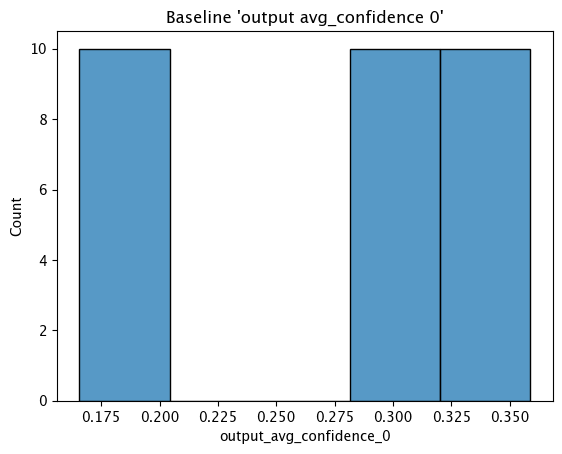

In [224]:
assay_builder_from_dates.baseline_histogram()

In [225]:
# create baseline from numpy

assay_name_from_dates = "average confidence drift detection numpy"
step_name = "resnet-with-intensity"
assay_builder_from_numpy = wl.build_assay(assay_name_from_dates, 
                               pipeline, 
                               step_name, 
                               iopath="output avg_confidence 0", 
                               baseline_data=avg_confidence_baseline)

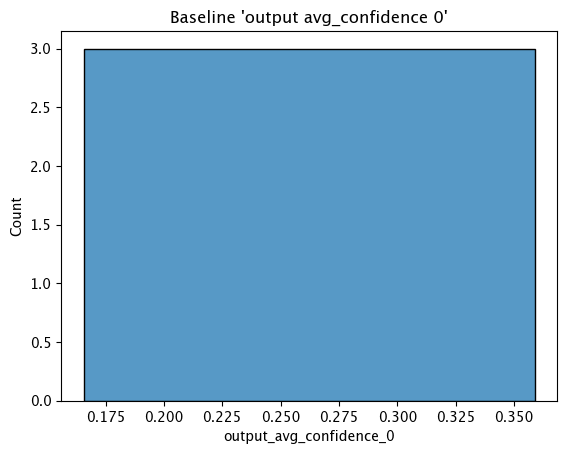

In [226]:
assay_builder_from_numpy.baseline_histogram()

In [229]:
# assay window from dates

assay_window_end = datetime.datetime.now()

assay_builder_from_dates = assay_builder_from_dates.add_run_until(assay_window_end)

# show just the ops


# View 1 minute intervals
assay_builder_from_dates.window_builder().add_width(minutes=6).add_interval(minutes=6).add_start(baseline_start)



Generated 1 analyses


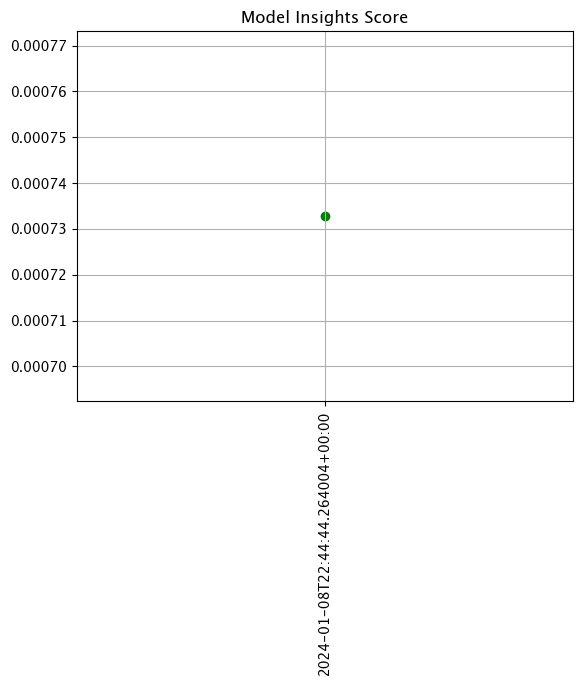

In [230]:
assay_config_from_dates = assay_builder_from_dates.build()
assay_results_from_dates = assay_config_from_dates.interactive_run()

print(f"Generated {len(assay_results_from_dates)} analyses")
assay_results_from_dates.chart_scores()

Publish the edge

In [86]:
pup = pipeline.publish()

Waiting for pipeline publish... It may take up to 600 sec.
Pipeline is Publishing......Published.


In [89]:
display(pup)

ID,1
Pipeline Version,27835e9e-0f65-4e14-a094-938e3f3af220
Status,Published
Engine URL,ghcr.io/wallaroolabs/doc-samples/engines/proxy/wallaroo/ghcr.io/wallaroolabs/standalone-mini:v2023.4.1-4351
Pipeline URL,ghcr.io/wallaroolabs/doc-samples/pipelines/retail-inv-tracker-edge-obs:27835e9e-0f65-4e14-a094-938e3f3af220
Helm Chart URL,oci://ghcr.io/wallaroolabs/doc-samples/charts/retail-inv-tracker-edge-obs
Helm Chart Reference,ghcr.io/wallaroolabs/doc-samples/charts@sha256:c4dc9bf29d0e062807d91bfc64b55dcb162a5d6d5c6f29ee2cb50cfbd39aaee1
Helm Chart Version,0.0.1-27835e9e-0f65-4e14-a094-938e3f3af220
Engine Config,"{'engine': {'resources': {'limits': {'cpu': 4.0, 'memory': '3Gi'}, 'requests': {'cpu': 4.0, 'memory': '3Gi'}, 'arch': 'x86', 'gpu': False}}, 'engineAux': {}, 'enginelb': {'resources': {'limits': {'cpu': 1.0, 'memory': '512Mi'}, 'requests': {'cpu': 0.2, 'memory': '512Mi'}, 'arch': 'x86', 'gpu': False}}}"
User Images,[]
Created By,john.hummel@wallaroo.ai


In [90]:
edge_name = 'azure-reactor-demo-sample'
edge_publish = pup.add_edge('azure-reactor-demo-sample')

In [169]:
edge_publish_azure = pup.add_edge('azure-reactor-demo-sample-vm')
edge_publish_azure

ID,1
Pipeline Version,27835e9e-0f65-4e14-a094-938e3f3af220
Status,Published
Engine URL,ghcr.io/wallaroolabs/doc-samples/engines/proxy/wallaroo/ghcr.io/wallaroolabs/standalone-mini:v2023.4.1-4351
Pipeline URL,ghcr.io/wallaroolabs/doc-samples/pipelines/retail-inv-tracker-edge-obs:27835e9e-0f65-4e14-a094-938e3f3af220
Helm Chart URL,oci://ghcr.io/wallaroolabs/doc-samples/charts/retail-inv-tracker-edge-obs
Helm Chart Reference,ghcr.io/wallaroolabs/doc-samples/charts@sha256:c4dc9bf29d0e062807d91bfc64b55dcb162a5d6d5c6f29ee2cb50cfbd39aaee1
Helm Chart Version,0.0.1-27835e9e-0f65-4e14-a094-938e3f3af220
Engine Config,"{'engine': {'resources': {'limits': {'cpu': 4.0, 'memory': '3Gi'}, 'requests': {'cpu': 4.0, 'memory': '3Gi'}, 'arch': 'x86', 'gpu': False}}, 'engineAux': {}, 'enginelb': {'resources': {'limits': {'cpu': 1.0, 'memory': '512Mi'}, 'requests': {'cpu': 0.2, 'memory': '512Mi'}, 'arch': 'x86', 'gpu': False}}}"
User Images,[]
Created By,john.hummel@wallaroo.ai


Add a location to the pipeline publish


In [91]:
edge_publish

ID,1
Pipeline Version,27835e9e-0f65-4e14-a094-938e3f3af220
Status,Published
Engine URL,ghcr.io/wallaroolabs/doc-samples/engines/proxy/wallaroo/ghcr.io/wallaroolabs/standalone-mini:v2023.4.1-4351
Pipeline URL,ghcr.io/wallaroolabs/doc-samples/pipelines/retail-inv-tracker-edge-obs:27835e9e-0f65-4e14-a094-938e3f3af220
Helm Chart URL,oci://ghcr.io/wallaroolabs/doc-samples/charts/retail-inv-tracker-edge-obs
Helm Chart Reference,ghcr.io/wallaroolabs/doc-samples/charts@sha256:c4dc9bf29d0e062807d91bfc64b55dcb162a5d6d5c6f29ee2cb50cfbd39aaee1
Helm Chart Version,0.0.1-27835e9e-0f65-4e14-a094-938e3f3af220
Engine Config,"{'engine': {'resources': {'limits': {'cpu': 4.0, 'memory': '3Gi'}, 'requests': {'cpu': 4.0, 'memory': '3Gi'}, 'arch': 'x86', 'gpu': False}}, 'engineAux': {}, 'enginelb': {'resources': {'limits': {'cpu': 1.0, 'memory': '512Mi'}, 'requests': {'cpu': 0.2, 'memory': '512Mi'}, 'arch': 'x86', 'gpu': False}}}"
User Images,[]
Created By,john.hummel@wallaroo.ai


In [92]:
# create docker run 

docker_command = f'''
docker run -p 8080:8080 \\
    -v ./data:/persist \\
    -e DEBUG=true \\
    -e OCI_REGISTRY=$REGISTRYURL \\
    -e EDGE_BUNDLE={edge_publish.docker_run_variables['EDGE_BUNDLE']} \\
    -e CONFIG_CPUS=6 \\
    -e OCI_USERNAME=$REGISTRYUSERNAME \\
    -e OCI_PASSWORD=$REGISTRYPASSWORD \\
    -e PIPELINE_URL={edge_publish.pipeline_url} \\
    {edge_publish.engine_url}
'''

print(docker_command)


docker run -p 8080:8080 \
    -v ./data:/persist \
    -e DEBUG=true \
    -e OCI_REGISTRY=$REGISTRYURL \
    -e EDGE_BUNDLE=ZXhwb3J0IEJVTkRMRV9WRVJTSU9OPTEKZXhwb3J0IEVER0VfTkFNRT1henVyZS1yZWFjdG9yLWRlbW8tc2FtcGxlCmV4cG9ydCBKT0lOX1RPS0VOPWQ3NzUwYTBhLTE4ZTAtNDkzNS04MjVkLWE0ZGJkODUyMjhkOQpleHBvcnQgT1BTQ0VOVEVSX0hPU1Q9ZG9jLXRlc3QuZWRnZS53YWxsYXJvb2NvbW11bml0eS5uaW5qYQpleHBvcnQgUElQRUxJTkVfVVJMPWdoY3IuaW8vd2FsbGFyb29sYWJzL2RvYy1zYW1wbGVzL3BpcGVsaW5lcy9yZXRhaWwtaW52LXRyYWNrZXItZWRnZS1vYnM6Mjc4MzVlOWUtMGY2NS00ZTE0LWEwOTQtOTM4ZTNmM2FmMjIwCmV4cG9ydCBXT1JLU1BBQ0VfSUQ9NQ== \
    -e CONFIG_CPUS=6 \
    -e OCI_USERNAME=$REGISTRYUSERNAME \
    -e OCI_PASSWORD=$REGISTRYPASSWORD \
    -e PIPELINE_URL=ghcr.io/wallaroolabs/doc-samples/pipelines/retail-inv-tracker-edge-obs:27835e9e-0f65-4e14-a094-938e3f3af220 \
    ghcr.io/wallaroolabs/doc-samples/engines/proxy/wallaroo/ghcr.io/wallaroolabs/standalone-mini:v2023.4.1-4351



In [170]:
# create docker run 

docker_command = f'''
docker run -p 8080:8080 \\
    -v ./data:/persist \\
    -e DEBUG=true \\
    -e OCI_REGISTRY=$REGISTRYURL \\
    -e EDGE_BUNDLE={edge_publish_azure.docker_run_variables['EDGE_BUNDLE']} \\
    -e CONFIG_CPUS=6 \\
    -e OCI_USERNAME=$REGISTRYUSERNAME \\
    -e OCI_PASSWORD=$REGISTRYPASSWORD \\
    -e PIPELINE_URL={edge_publish_azure.pipeline_url} \\
    {edge_publish_azure.engine_url}
'''

print(docker_command)


docker run -p 8080:8080 \
    -v ./data:/persist \
    -e DEBUG=true \
    -e OCI_REGISTRY=$REGISTRYURL \
    -e EDGE_BUNDLE=ZXhwb3J0IEJVTkRMRV9WRVJTSU9OPTEKZXhwb3J0IEVER0VfTkFNRT1henVyZS1yZWFjdG9yLWRlbW8tc2FtcGxlLXZtCmV4cG9ydCBKT0lOX1RPS0VOPTVlNDhmNDQxLWZiZjItNDU1Zi1iZTk5LTE4MmFkNGExMWNlNwpleHBvcnQgT1BTQ0VOVEVSX0hPU1Q9ZG9jLXRlc3QuZWRnZS53YWxsYXJvb2NvbW11bml0eS5uaW5qYQpleHBvcnQgUElQRUxJTkVfVVJMPWdoY3IuaW8vd2FsbGFyb29sYWJzL2RvYy1zYW1wbGVzL3BpcGVsaW5lcy9yZXRhaWwtaW52LXRyYWNrZXItZWRnZS1vYnM6Mjc4MzVlOWUtMGY2NS00ZTE0LWEwOTQtOTM4ZTNmM2FmMjIwCmV4cG9ydCBXT1JLU1BBQ0VfSUQ9NQ== \
    -e CONFIG_CPUS=6 \
    -e OCI_USERNAME=$REGISTRYUSERNAME \
    -e OCI_PASSWORD=$REGISTRYPASSWORD \
    -e PIPELINE_URL=ghcr.io/wallaroolabs/doc-samples/pipelines/retail-inv-tracker-edge-obs:27835e9e-0f65-4e14-a094-938e3f3af220 \
    ghcr.io/wallaroolabs/doc-samples/engines/proxy/wallaroo/ghcr.io/wallaroolabs/standalone-mini:v2023.4.1-4351



In [231]:
import datetime

inference_start = datetime.datetime.now()

# api based inference request
import requests

headers = wl.auth.auth_header()

headers['Content-Type'] = 'application/json; format=pandas-records'

deploy_url = pipeline._deployment._url()

response = requests.post(
                    deploy_url, 
                    headers=headers, 
                    data=df_test.to_json(orient="records")
                )



In [232]:
display(pd.DataFrame(response.json()))

,time,in,out,check_failures,metadata
0,1704754376122,"{'tensor': [0.9450980425, 0.9411764741, 0.9411764741, 0.9411764741, 0.9450980425, 0.9450980425, 0.9450980425, 0.9450980425, 0.9450980425, 0.9450980425, 0.9450980425, 0.9450980425, 0.9450980425, 0.9450980425, 0.9450980425, 0.9450980425, 0.9450980425, 0.9450980425, 0.9490196109, 0.9450980425, 0.9490196109, 0.9490196109, 0.9529411793, 0.9529411793, 0.9568627477, 0.9568627477, 0.9607843161, 0.9607843161, 0.9607843161, 0.9607843161, 0.9607843161, 0.9607843161, 0.9607843161, 0.9568627477, 0.9568627477, 0.9568627477, 0.9568627477, 0.9529411793, 0.9529411793, 0.9490196109, 0.9490196109, 0.9490196109, 0.9450980425, 0.9411764741, 0.9411764741, 0.9411764741, 0.9411764741, 0.9333333373, 0.9294117689, 0.9294117689, 0.9294117689, 0.9254902005, 0.9176470637, 0.9215686321, 0.9254902005, 0.9372549057, 0.9450980425, 0.9529411793, 0.9568627477, 0.9686274529, 0.9725490212, 0.9725490212, 0.9725490212, 0.9764705896, 0.9607843161, 0.8980392218, 0.8274509907, 0.7450980544, 0.650980413, 0.5568627715, 0.4666666687, 0.3843137324, 0.3411764801, 0.3372549117, 0.3411764801, 0.3647058904, 0.3960784376, 0.4352941215, 0.4784313738, 0.5176470876, 0.5568627715, 0.5960784554, 0.631372571, 0.6627451181, 0.6980392337, 0.7294117808, 0.7725490332, 0.8196078539, 0.8549019694, 0.8862745166, 0.9176470637, 0.9411764741, 0.9647058845, 0.9686274529, 0.9647058845, 0.9607843161, 0.9607843161, 0.9607843161, 0.9607843161, 0.9607843161, ...]}","{'avg_confidence': [0.29440108], 'avg_px_intensity': [0.42540666], 'boxes': [[1.104647, 203.48311, 81.29011, 472.4321], [67.34002, 195.64558, 163.41652, 470.1668], [218.88916, 180.21216, 281.3725, 422.2332], [156.47955, 189.82559, 227.1866, 443.35718], [393.81195, 172.34473, 434.30322, 363.96057], [266.56137, 201.46182, 326.2503, 406.3162], [542.941, 99.440956, 588.42365, 229.33481], [426.12668, 260.50723, 638.6193, 476.10742], [511.26102, 106.84715, 546.8103, 243.0127], [0.0, 68.56848, 482.48538, 472.53766], [347.34027, 0.0, 401.10968, 97.51968], [289.03827, 0.32189485, 347.78888, 93.458755], [91.05826, 183.34473, 207.86084, 469.46518], [613.1202, 102.11072, 639.4794, 228.7474], [369.04257, 177.80518, 419.34775, 371.53873], [512.19727, 92.89032, 548.08636, 239.37686], [458.50125, 115.80958, 485.57538, 236.75961], [571.35834, 102.115395, 620.06, 230.47636], [481.23752, 105.288246, 516.5597, 246.37486], [74.288246, 0.4324219, 162.55719, 80.09118], [566.6188, 102.72982, 623.63257, 226.31448], [14.5338335, 0.0, 410.35077, 100.371155], [67.72321, 186.76591, 144.67079, 272.91965], [171.88432, 1.3620621, 220.8489, 82.6873], [455.16003, 109.83146, 486.36246, 243.25917], [320.3717, 211.61632, 373.62762, 397.29614], [476.53476, 105.55374, 517.4519, 240.22443], [530.3071, 97.575066, 617.83466, 235.27464], [146.26923, 184.24777, 186.76619, 459.51907], [610.5376, 99.28521, 638.6954, 235.62247], [316.39325, 194.10446, 375.8869, 401.48578], [540.51245, 105.909325, 584.589, 239.12834], [460.5496, 313.47333, 536.9969, 447.4658], [222.15643, 206.45018, 282.35947, 423.1165], [80.06503, 0.0, 157.40846, 79.61287], [396.70865, 235.83214, 638.7461, 473.58328], [494.6364, 115.012085, 520.81445, 241.98145], [432.90045, 145.19109, 464.7877, 264.47726], [200.3818, 181.47552, 232.85869, 429.13736], [50.631256, 161.2574, 321.71106, 465.66733], [545.57556, 106.189095, 593.3653, 227.64984], [338.0726, 1.0913361, 413.84973, 101.5233], [364.8136, 178.95511, 410.21368, 373.15686], [392.6712, 173.77844, 434.40182, 370.18982], [361.36926, 175.07799, 397.51382, 371.78812], [158.44263, 182.24762, 228.91519, 445.61328], [282.683, 0.0, 348.24307, 92.91383], [0.0, 194.40187, 640.0, 474.7329], [276.38458, 260.773, 326.8054, 407.18048], [528.4028, 105.582886, 561.3014, 239.953], [506.40353, 115.89468, 526.7106, 233.26082], [20.692535, 4.8851624, 441.1723, 215.57448], [193.52037, 188.48592, 329.2185, 428.5391], [1.6791562, 122.02866, 481.69287, 463.82855], [255.57025, 0.0, 396.8555, 100.11973], [457.83475, 91.354, 534.8592, 2

In [233]:
import datetime

time.sleep(10)

inference_start = datetime.datetime.now()

# verify the pipeline is running

import requests

url = 'http://testboy.local:8080/pipelines'

response = requests.get(
    url=url
)

print(response.text)

# inference time

headers2 = {
    'Content-Type': 'application/json; format=pandas-records'
}

url = 'http://testboy.local:8080/pipelines/retail-inv-tracker-edge-obs'

edge_response = requests.post(
                    url, 
                    headers=headers2,
                    data=df_test.to_json(orient="records")
                )

display(pd.DataFrame(edge_response.json()))


{"pipelines":[{"id":"retail-inv-tracker-edge-obs","status":"Running"}]}


,time,in,out,check_failures,metadata
0,1704754402738,"{'tensor': [0.9450980425, 0.9411764741, 0.9411764741, 0.9411764741, 0.9450980425, 0.9450980425, 0.9450980425, 0.9450980425, 0.9450980425, 0.9450980425, 0.9450980425, 0.9450980425, 0.9450980425, 0.9450980425, 0.9450980425, 0.9450980425, 0.9450980425, 0.9450980425, 0.9490196109, 0.9450980425, 0.9490196109, 0.9490196109, 0.9529411793, 0.9529411793, 0.9568627477, 0.9568627477, 0.9607843161, 0.9607843161, 0.9607843161, 0.9607843161, 0.9607843161, 0.9607843161, 0.9607843161, 0.9568627477, 0.9568627477, 0.9568627477, 0.9568627477, 0.9529411793, 0.9529411793, 0.9490196109, 0.9490196109, 0.9490196109, 0.9450980425, 0.9411764741, 0.9411764741, 0.9411764741, 0.9411764741, 0.9333333373, 0.9294117689, 0.9294117689, 0.9294117689, 0.9254902005, 0.9176470637, 0.9215686321, 0.9254902005, 0.9372549057, 0.9450980425, 0.9529411793, 0.9568627477, 0.9686274529, 0.9725490212, 0.9725490212, 0.9725490212, 0.9764705896, 0.9607843161, 0.8980392218, 0.8274509907, 0.7450980544, 0.650980413, 0.5568627715, 0.4666666687, 0.3843137324, 0.3411764801, 0.3372549117, 0.3411764801, 0.3647058904, 0.3960784376, 0.4352941215, 0.4784313738, 0.5176470876, 0.5568627715, 0.5960784554, 0.631372571, 0.6627451181, 0.6980392337, 0.7294117808, 0.7725490332, 0.8196078539, 0.8549019694, 0.8862745166, 0.9176470637, 0.9411764741, 0.9647058845, 0.9686274529, 0.9647058845, 0.9607843161, 0.9607843161, 0.9607843161, 0.9607843161, 0.9607843161, ...]}","{'avg_confidence': [0.29440096], 'avg_px_intensity': [0.42540666], 'boxes': [[1.104647, 203.48311, 81.29011, 472.4321], [67.340034, 195.6456, 163.41652, 470.16684], [218.88916, 180.21216, 281.3725, 422.23322], [156.47955, 189.8256, 227.1866, 443.35718], [393.81195, 172.3447, 434.30322, 363.96063], [266.56137, 201.46165, 326.2503, 406.31613], [542.941, 99.440956, 588.42365, 229.33481], [426.12668, 260.50723, 638.6193, 476.10742], [511.26102, 106.84715, 546.8103, 243.0127], [0.0, 68.56848, 482.48535, 472.53766], [347.34027, 0.0, 401.10968, 97.51969], [289.03827, 0.32189026, 347.78888, 93.45876], [91.05832, 183.34473, 207.86087, 469.46518], [613.1202, 102.11072, 639.4794, 228.7474], [369.04257, 177.80518, 419.34775, 371.53873], [512.19727, 92.89032, 548.08636, 239.37686], [458.50125, 115.80958, 485.57538, 236.75961], [571.35834, 102.115395, 620.06, 230.47636], [481.23752, 105.288246, 516.5597, 246.37486], [74.28825, 0.4324219, 162.55719, 80.09118], [566.6188, 102.72982, 623.63257, 226.31448], [14.533815, 0.0, 410.35083, 100.371155], [67.7232, 186.76591, 144.6708, 272.91965], [171.88432, 1.3620713, 220.8489, 82.6873], [455.16003, 109.83144, 486.36246, 243.25916], [320.3717, 211.61633, 373.62762, 397.2961], [476.53476, 105.553734, 517.4519, 240.22444], [530.3071, 97.575066, 617.83466, 235.27464], [146.26923, 184.2478, 186.7662, 459.51904], [610.5375, 99.28521, 638.6953, 235.62251], [316.39325, 194.10446, 375.8869, 401.48578], [540.51245, 105.909355, 584.589, 239.12836], [460.5496, 313.47333, 536.9969, 447.4658], [222.1564, 206.45021, 282.3595, 423.11642], [80.06504, 0.0, 157.40845, 79.61287], [396.70865, 235.83217, 638.7461, 473.58328], [494.6365, 115.012085, 520.81445, 241.98145], [432.90045, 145.19107, 464.7877, 264.47726], [200.3818, 181.47552, 232.85869, 429.13736], [50.631268, 161.25745, 321.7111, 465.66736], [545.57556, 106.189095, 593.36536, 227.64984], [338.0726, 1.0913361, 413.84973, 101.52331], [364.8136, 178.9551, 410.21368, 373.15683], [392.6712, 173.77847, 434.40182, 370.18982], [361.36926, 175.07799, 397.51382, 371.78812], [158.44263, 182.24762, 228.91519, 445.61328], [282.68304, 0.0, 348.2431, 92.91383], [0.0, 194.40187, 640.0, 474.73285], [276.38458, 260.773, 326.8054, 407.18048], [528.4028, 105.58293, 561.30133, 239.95299], [506.40353, 115.89469, 526.7106, 233.26079], [20.692553, 4.8851624, 441.1723, 215.57448], [193.52036, 188.4859, 329.21844, 428.5391], [1.6791195, 122.02865, 481.69287, 463.82858], [255.57033, 0.0, 396.8555, 100.11974], [457.83475, 91.354004, 534.8592, 

In [236]:
# provide time for the log writes to complete from the edge devices
time.sleep(30)
pipeline.logs(dataset=['time', 'out.avg_confidence', 'metadata'])

,time,out.avg_confidence,metadata.last_model,metadata.pipeline_version,metadata.elapsed,metadata.dropped,metadata.partition
0,2024-01-08 22:52:56.122,[0.29440108],"{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}",655dd997-120c-4fc0-a780-0b8a332c6fcb,"[155355840, 6723790590]",[in.tensor],engine-7f8744889c-45v8p
1,2024-01-08 22:51:40.960,[0.16569331],"{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}",655dd997-120c-4fc0-a780-0b8a332c6fcb,"[164140588, 6985239240]",[in.tensor],engine-7f8744889c-45v8p
2,2024-01-08 22:51:21.864,[0.29708874],"{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}",655dd997-120c-4fc0-a780-0b8a332c6fcb,"[154193658, 6980558372]",[in.tensor],engine-7f8744889c-45v8p
3,2024-01-08 22:51:09.311,[0.35880384],"{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}",655dd997-120c-4fc0-a780-0b8a332c6fcb,"[156291315, 7037645301]",[in.tensor],engine-7f8744889c-45v8p
4,2024-01-08 22:50:53.110,[0.16569331],"{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}",655dd997-120c-4fc0-a780-0b8a332c6fcb,"[156459021, 7116809766]",[in.tensor],engine-7f8744889c-45v8p
5,2024-01-08 22:50:39.713,[0.29708874],"{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}",655dd997-120c-4fc0-a780-0b8a332c6fcb,"[159342980, 7031568723]",[in.tensor],engine-7f8744889c-45v8p
6,2024-01-08 22:50:27.927,[0.35880384],"{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}",655dd997-120c-4fc0-a780-0b8a332c6fcb,"[159889956, 7202154515]",[in.tensor],engine-7f8744889c-45v8p
7,2024-01-08 22:50:08.684,[0.16569331],"{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}",655dd997-120c-4fc0-a780-0b8a332c6fcb,"[155899638, 7355897345]",[in.tensor],engine-7f8744889c-45v8p
8,2024-01-08 22:49:53.283,[0.29708874],"{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}",655dd997-120c-4fc0-a780-0b8a332c6fcb,"[159114212, 7155455624]",[in.tensor],engine-7f8744889c-45v8p
9,2024-01-08 22:49:42.609,[0.35880384],"{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}",655dd997-120c-4fc0-a780-0b8a332c6fcb,"[153574595, 7037052235]",[in.tensor],engine-7f8744889c-45v8p


In [ ]:
# inference testing time

In [239]:
assay_window_start = datetime.datetime.now()

for i in range(10):
    for good_image in baseline_images_list:
        ops_pipeline_inference(good_image)

,time,metadata
0,1704755374961,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [164970087, 7181669830], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704755387333,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [156592178, 7012015750], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704755400419,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [157525890, 7225004975], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704755413405,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [156191981, 7237026576], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704755425121,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [156695575, 7123951624], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704755445699,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [156576365, 7020516726], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704755457881,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [155479762, 7064568998], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704755468841,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [158190098, 7002411077], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704755481064,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [155846167, 6872723072], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704755492811,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [153498437, 7034302830], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704755514209,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [155318644, 6734910513], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704755536232,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [155211560, 6814652475], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704755565419,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [156945345, 6820560647], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704755588222,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [194529521, 7128824987], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704755610440,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [154094098, 7090740308], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704755621748,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [156954483, 7077351187], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704755634419,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [156822802, 7127943100], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704755661413,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [173740110, 7025680770], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704755680463,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [152269444, 6772419312], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704755691924,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [156279856, 6508731525], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704755709976,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [182339839, 7561262419], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704755723721,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [159294349, 7121700584], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704755750411,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [157929441, 7027482604], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704755761624,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [155358116, 6715224355], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704755772428,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [153992507, 6712523936], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704755784016,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [154061112, 6829997328], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704755796725,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [155722996, 7012360841], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704755808363,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [156982342, 6779423270], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704755830409,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [152318551, 6729033613], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704755851590,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [163410410, 6946830253], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


In [240]:
# assay from recent updates

assay_window_end = datetime.datetime.now()

assay_builder_from_dates = assay_builder_from_dates.add_run_until(assay_window_end)

# show just the ops


# View 1 minute intervals
# just ops
(assay_builder_from_dates
    .window_builder()
    .add_width(minutes=6)
    .add_interval(minutes=6)
    .add_start(assay_window_start)
    .add_location_filter([ops_partition, edge_name])
)



Generated 1 analyses


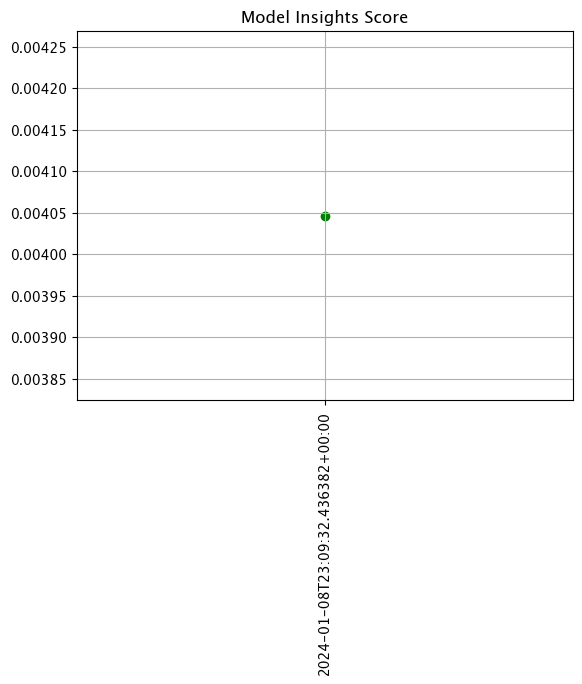

In [241]:
assay_config = assay_builder_from_dates.build()
assay_results = assay_config.interactive_run()

print(f"Generated {len(assay_results)} analyses")
assay_results.chart_scores()

In [242]:
for i in range(1):
    for bad_image in blurred_images_list:
        edge_pipeline_inference(bad_image)
for i in range(9):
    for good_image in baseline_images_list:
        ops_pipeline_inference(good_image)


,time,metadata
0,1704756005576,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [236728210, 2222815628], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704756015493,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [238081865, 1797424873], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704756025197,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [236873625, 2229277000], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704756035324,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [161737031, 7223751320], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704756046964,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [156990825, 7059497240], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704756058986,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [152702718, 7061104471], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704756070934,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [156468535, 7099927028], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704756090908,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [152785910, 6837018367], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704756116985,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [154880747, 6648906480], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704756129535,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [156285764, 6712158885], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704756156047,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [155945562, 6787727763], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704756170855,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [157089668, 6775092997], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704756194972,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [160508276, 7257279896], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704756216214,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [155255148, 7130784414], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704756228560,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [154915428, 7082138520], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704756241766,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [157684866, 7069230568], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704756267940,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [156835447, 7202226570], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704756292038,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [157091065, 7008835224], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704756317140,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [153103707, 7192604509], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704756331354,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [158736381, 7092775013], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704756352793,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [153732953, 7050716580], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704756377886,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [154079522, 6858707936], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704756406149,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [155909506, 7084437272], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704756420774,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [156425048, 6677916799], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704756443093,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [161584991, 6943608032], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704756456782,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [158343372, 6652806722], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704756468810,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [157293173, 6630822184], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704756480981,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [153939824, 6568357826], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704756495194,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [156393651, 7152835705], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704756513230,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [156598937, 6817722647], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


In [243]:
# assay window from numpy

# assay window from dates

assay_window_end = datetime.datetime.now()

assay_builder_from_numpy = assay_builder_from_numpy.add_run_until(assay_window_end)

# show just the ops


# View 1 minute intervals
# just combined
(assay_builder_from_numpy
    .window_builder()
    .add_width(minutes=6)
    .add_interval(minutes=6)
    .add_start(assay_window_start)
    .add_location_filter([ops_partition, edge_name])
)



Generated 3 analyses


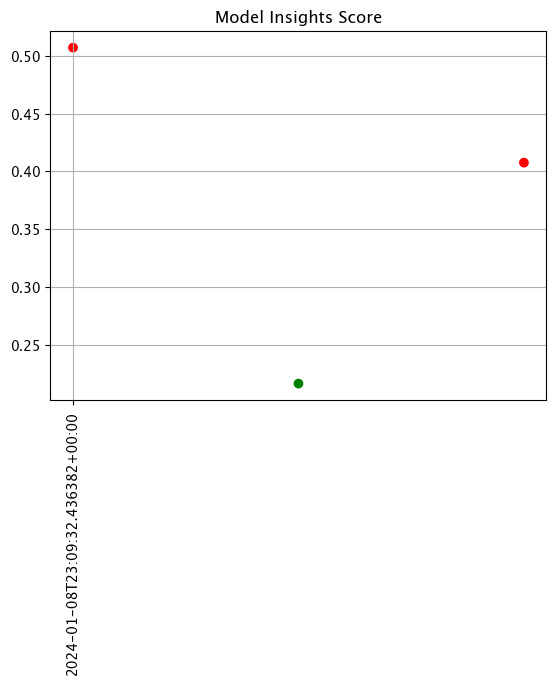

In [244]:
assay_config_from_numpy = assay_builder_from_numpy.build()
assay_results_from_numpy = assay_config_from_numpy.interactive_run()

print(f"Generated {len(assay_results_from_numpy)} analyses")
assay_results_from_numpy.chart_scores()

In [245]:
for i in range(8):
    for good_image in baseline_images_list:
        ops_pipeline_inference(good_image)
for i in range(2):
    for bad_image in blurred_images_list:
        edge_pipeline_inference(bad_image)

,time,metadata
0,1704756543458,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [156735607, 6789369968], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704756568556,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [161337797, 7079809877], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704756589195,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [156500130, 6648802664], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704756601018,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [156503731, 7230965813], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704756615127,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [175060372, 7217585606], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704756628025,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [155381488, 7205757657], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704756648801,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [158908566, 7044158758], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704756672273,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [163210527, 7058295599], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704756699844,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [167975089, 6994802845], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704756729208,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [155010438, 6738777335], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704756760243,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [155522233, 6793710174], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704756777961,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [158150366, 6676689388], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704756789632,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [159097472, 7315519563], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704756817094,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [158695463, 7037510132], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704756840912,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [159124778, 7220518167], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704756852398,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [159267080, 7243002157], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704756864620,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [199935300, 7026738907], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704756892498,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [156453355, 6931849527], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704756911022,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [158452181, 7213146308], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704756930698,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [158656484, 7245178058], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704756955043,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [158911163, 6897703144], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704756972641,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [156314267, 6897069791], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704756985025,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [170586853, 6816502864], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704757012156,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [152153271, 6587462057], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704757042195,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [234883692, 1744737989], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704757051251,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [234570323, 2274642127], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704757062093,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [234721290, 1726263124], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704757074064,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [236480626, 1746554913], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704757084656,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [235829079, 1751629623], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704757095522,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [244486855, 1770089980], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


In [246]:
for i in range(7):
    for good_image in baseline_images_list:
        ops_pipeline_inference(good_image)
for i in range(3):
    for bad_image in blurred_images_list:
        edge_pipeline_inference(bad_image)

,time,metadata
0,1704757104438,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [153830892, 7190738102], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704757133343,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [155767902, 7001566451], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704757160219,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [162764991, 7032411570], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704757190505,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [158099598, 6916325221], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704757221723,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [164996987, 7215379537], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704757254058,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [153943758, 6989933057], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704757281922,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [158964597, 6822106107], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704757308540,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [156985952, 6990772295], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704757338408,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [154634902, 6728150246], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704757361930,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [156941751, 6506329664], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704757384441,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [167246224, 7093582476], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704757400213,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [174108120, 7118264911], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704757428568,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [157124038, 7082605186], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704757454632,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [158898995, 7104584166], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704757477470,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [164129864, 6973985846], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704757500065,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [165872265, 7081841844], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704757526271,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [161920504, 7061570163], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704757551250,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [169062585, 7092956778], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704757571324,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [156242654, 7211428241], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704757593313,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [161090919, 7121626438], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704757618540,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [157109064, 7004816422], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704757649460,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [233831748, 1733354012], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704757659362,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [235288829, 1747455060], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704757670099,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [235792515, 1743926504], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704757680739,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [233658024, 1798232105], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704757691244,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [244041156, 1733399228], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704757701079,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [241746048, 1800633803], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704757711437,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [236805960, 1699814622], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704757721606,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [242196654, 2254409986], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704757731962,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [233482046, 1788481727], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


In [247]:
for i in range(6):
    for good_image in baseline_images_list:
        ops_pipeline_inference(good_image)
for i in range(4):
    for bad_image in blurred_images_list:
        edge_pipeline_inference(bad_image)

,time,metadata
0,1704757740844,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [157470250, 7001543257], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704757761554,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [159820881, 6989825318], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704757777535,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [158817301, 7110908956], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704757791418,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [164831371, 6915575013], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704757806081,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [169567200, 7164406138], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704757827430,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [155025425, 7309210319], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704757854142,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [155915057, 7098013682], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704757877608,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [154022303, 7022750235], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704757900986,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [155066294, 7062158310], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704757914808,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [155391302, 6934755634], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704757943134,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [158037769, 6892968443], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704757970142,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [157671202, 6603382657], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704757997825,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [170238948, 7007150447], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704758009272,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [158655196, 6969289745], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704758026248,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [154550911, 6890754455], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704758043268,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [159076591, 7068435168], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704758068979,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [158601668, 7153239486], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704758101438,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [155924512, 7107086691], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704758132527,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [235591653, 2227143153], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704758143059,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [235414896, 1735830756], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704758153611,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [232891697, 2242529150], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704758164643,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [230786492, 1769833866], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704758174503,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [231938756, 2284886345], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704758185319,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [231054916, 1760162645], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704758195320,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [241025646, 2189098926], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704758206305,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [236865036, 1779697176], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704758217932,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [244359154, 2201495856], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704758229095,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [237033777, 1678577756], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704758239390,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [241948124, 2218355264], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704758250378,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [236574111, 1722310076], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


In [257]:
# assay window from numpy

# assay window from dates

assay_window_end = datetime.datetime.now()

assay_builder_from_numpy = assay_builder_from_numpy.add_run_until(assay_window_end)

# show just the ops


# View 1 minute intervals
# just combined
(assay_builder_from_numpy
    .window_builder()
    .add_width(minutes=7)
    .add_interval(minutes=7)
    .add_start(assay_window_start)
    .add_location_filter([ops_partition, edge_name])
)



Generated 8 analyses


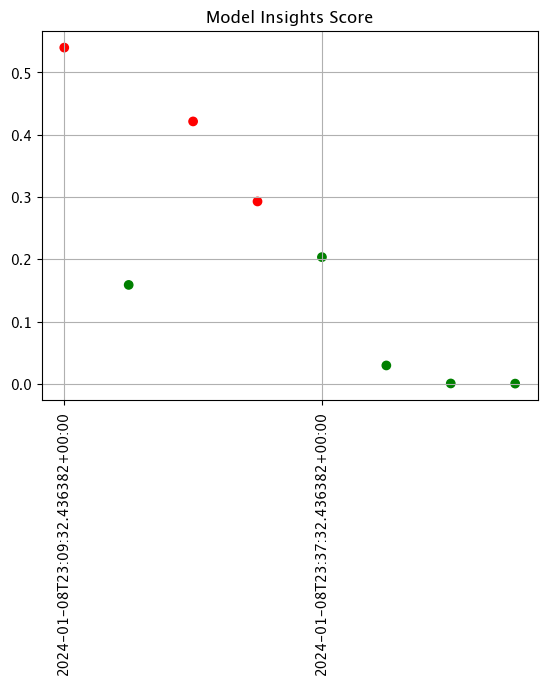

In [258]:
assay_config_from_numpy = assay_builder_from_numpy.build()
assay_results_from_numpy = assay_config_from_numpy.interactive_run()

print(f"Generated {len(assay_results_from_numpy)} analyses")
assay_results_from_numpy.chart_scores()

In [259]:
for i in range(5):
    for good_image in baseline_images_list:
        ops_pipeline_inference(good_image)
for i in range(5):
    for bad_image in blurred_images_list:
        edge_pipeline_inference(bad_image)

,time,metadata
0,1704758852246,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [157129040, 6694836260], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704758865197,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [154125907, 6834474893], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704758881014,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [159702452, 7032372064], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704758895844,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [168663492, 7094203945], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704758919546,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [160338508, 7003472547], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704758945422,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [167595296, 7020646032], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704758965111,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [157126848, 6937378738], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704758988580,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [154403474, 6550639565], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704759011573,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [166318462, 7165645501], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704759041912,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [161774005, 7028448193], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704759063879,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [158486955, 6962920573], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704759086237,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [157484147, 7082902929], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704759105897,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [153257593, 7043532233], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704759124675,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [159289377, 6769302847], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704759155236,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [158059179, 6911881860], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704759188207,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [237253369, 1722791633], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704759197132,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [235258338, 1776095022], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704759206504,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [234034634, 1720919205], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704759215239,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [228462431, 1804982897], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704759223911,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [244776408, 1722241531], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704759232906,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [236613006, 1750292706], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704759242764,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [237092014, 1760772864], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704759252652,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [245422720, 1768354570], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704759263441,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [235758513, 1745458523], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704759274127,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [235364816, 1706323063], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704759284274,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [238213178, 1791635188], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704759295199,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [230551056, 1721432104], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704759305918,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [237760868, 1774838558], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704759316492,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [246594603, 1736098997], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704759334004,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [237587606, 1733091506], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


In [260]:
for i in range(4):
    for good_image in baseline_images_list:
        ops_pipeline_inference(good_image)
for i in range(6):
    for bad_image in blurred_images_list:
        edge_pipeline_inference(bad_image)

,time,metadata
0,1704759348628,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [157049860, 7114739521], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704759360952,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [165944452, 7181484692], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704759379928,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [173749488, 7015803380], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704759409890,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [160971157, 7054754455], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704759423440,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [161736651, 6905028459], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704759444076,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [159427417, 6856731959], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704759456041,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [159581166, 6596246498], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704759467566,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [156161139, 6667720486], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704759489504,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [159028010, 6642185369], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704759502311,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [158738302, 7019334274], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704759521424,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [152854412, 6713200253], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704759538113,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [158585695, 6916927496], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704759555985,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [238328384, 1723662592], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704759564726,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [234328105, 1746087961], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704759576242,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [235211940, 1735837990], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704759586065,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [232166889, 1638539388], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704759595800,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [242833247, 1761042487], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704759605505,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [231863231, 2146808642], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704759615827,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [230281521, 1708633438], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704759627204,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [239028709, 2141285191], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704759638157,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [244350606, 1779381046], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704759653206,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [236146318, 2178296014], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704759669136,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [236699357, 1812036935], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704759689051,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [236700375, 2153110783], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704759703095,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [235448193, 1782466576], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704759714646,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [232038591, 2164319098], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704759726138,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [238019392, 1755245315], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704759740525,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [237269872, 2142182034], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704759761437,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [245110804, 1746968654], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704759775673,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [237356203, 2180660179], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


In [261]:
for i in range(3):
    for good_image in baseline_images_list:
        ops_pipeline_inference(good_image)
for i in range(7):
    for bad_image in blurred_images_list:
        edge_pipeline_inference(bad_image)

,time,metadata
0,1704759790731,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [178082613, 7108139303], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704759803709,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [157256245, 7123875270], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704759816903,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [154602611, 7145126515], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704759832435,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [155256618, 7009356785], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704759845926,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [169904530, 7019084926], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704759863317,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [160403980, 7027991090], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704759875256,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [154670501, 6988491904], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704759887041,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [195341339, 7103174336], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704759898970,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [167004566, 7276730523], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704759917291,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [236798969, 1733362798], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704759947408,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [232979193, 2243788485], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704759977329,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [231280001, 1712764671], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704759989811,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [230768244, 2152431717], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704760007647,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [232030226, 1809111991], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704760030261,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [236718459, 2183590046], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704760065659,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [236713791, 1756054681], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704760094611,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [235350243, 2210224724], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704760124937,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [228847835, 1745691941], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704760139900,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [228907733, 1788729497], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704760156104,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [237443362, 1722792001], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704760169110,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [232487466, 1718578647], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704760183727,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [226727402, 1727670630], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704760201576,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [233765123, 1772073061], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704760218280,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [231367361, 1716741609], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704760231038,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [236756504, 1737514571], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704760245383,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [238515886, 1775598524], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704760261320,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [234760713, 1811423126], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704760276190,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [233603220, 1724730478], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704760289164,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [235751580, 1768942028], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704760301854,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [243845521, 1718685648], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


In [262]:
for i in range(2):
    for good_image in baseline_images_list:
        ops_pipeline_inference(good_image)
for i in range(8):
    for bad_image in blurred_images_list:
        edge_pipeline_inference(bad_image)

,time,metadata
0,1704760316227,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [156343674, 7105854577], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704760328195,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [162318069, 6751023482], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704760340322,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [155146344, 6910708696], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704760357935,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [158116195, 6605598951], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704760389308,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [184354033, 7121302272], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704760408658,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [154392338, 7179113242], 'dropped': [], 'partition': 'engine-7f8744889c-45v8p'}"


,time,metadata
0,1704760421388,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [241082672, 1692760876], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704760434140,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [234567907, 1744437212], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704760448977,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [232764842, 1758388795], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704760465443,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [226823572, 1682464900], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704761262719,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [242068152, 1746842716], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704761632437,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [253175101, 1710363736], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704761648126,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [243866042, 2135708516], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704761665255,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [231697532, 1686334506], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704761678920,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [238892544, 2194142084], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704761695758,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [233263843, 1703740220], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704761711821,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [234238418, 2173919205], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704761726283,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [234673661, 1692142905], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704761758681,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [233655357, 2154831588], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704761772314,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [231603240, 1764197400], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704761788673,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [232045136, 2171860634], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704761805153,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [230424036, 1761208866], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704761821967,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [232289808, 2190947808], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704761836991,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [236736765, 1713011293], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704761851564,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [234961689, 2151751013], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704761866890,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [227122320, 1759450729], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704761884300,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [238618874, 2168198431], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704761902791,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [232553395, 1673487742], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704761916528,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [232198212, 2220483590], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704761931185,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [235107952, 1749347464], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


In [279]:
for i in range(1):
    for good_image in baseline_images_list:
        ops_pipeline_inference(good_image)
for i in range(9):
    for bad_image in blurred_images_list:
        edge_pipeline_inference(bad_image)

,time,metadata
0,1704812856616,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [198758021, 7146355084], 'dropped': [], 'partition': 'engine-7f8744889c-nhf72'}"


,time,metadata
0,1704812867927,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [170571926, 6930202921], 'dropped': [], 'partition': 'engine-7f8744889c-nhf72'}"


,time,metadata
0,1704812880062,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '655dd997-120c-4fc0-a780-0b8a332c6fcb', 'elapsed': [168793756, 6690904798], 'dropped': [], 'partition': 'engine-7f8744889c-nhf72'}"


,time,metadata
0,1704812908574,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [254119860, 2422697545], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704812920294,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [229973804, 2377505515], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704812931211,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [232460083, 2019604828], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704812942308,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [234002620, 2201895041], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704812953704,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [228430588, 1789211233], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704812964989,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [229047855, 2225064153], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704812975343,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [227962909, 1697089175], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704812986106,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [226093012, 2170728805], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704812997454,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [226583375, 1789309357], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704813008310,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [231650457, 2170280470], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704813019636,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [206802668, 1798796286], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704813030379,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [217775988, 1802129148], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704813041730,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [229757767, 1774917760], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704813053177,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [227611689, 2165450633], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704813066136,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [241014175, 1785267954], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704813077813,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [242186602, 2152709600], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704813089360,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [240606323, 1802215516], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704813100316,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [230420311, 2180868292], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704813111320,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [243828088, 1706317943], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704813121989,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [243022674, 2169304643], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704813133655,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [202331263, 1752671078], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704813146130,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [241977833, 2192810636], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704813159358,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [242777831, 1745746222], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704813169432,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [231202251, 2191694019], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704813183497,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [241212090, 1731194189], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704813197624,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [231170120, 2142603633], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704813210935,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [244486739, 1684788065], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


In [280]:
for i in range(10):
    for bad_image in blurred_images_list:
        edge_pipeline_inference(bad_image)

,time,metadata
0,1704813223336,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [242592048, 2186467576], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704813235745,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [241471474, 1787653112], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704813249348,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [240003798, 2162024105], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704813262931,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [242683033, 1802748060], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704813275299,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [242786882, 2136298411], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704813288155,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [241831276, 1779759898], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704813300625,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [242731933, 2135200087], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704813313534,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [230222311, 1787948230], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704813325928,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [242178660, 2123463315], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704813338325,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [228191603, 1700321211], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704813350030,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [245265824, 2140095635], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704813362704,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [243128994, 1759236790], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704813372805,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [243656000, 2116195386], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704813383287,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [242825767, 1757632658], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704813393813,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [236245964, 2104015703], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704813404425,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [229441937, 1790968854], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704813416136,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [241755850, 2165754658], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704813427012,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [238495977, 1756202695], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704813437424,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [234594453, 2136494055], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704813448580,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [239087607, 1801141758], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704813459153,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [235811773, 2129208661], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704813471647,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [235960484, 1717678577], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704813482656,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [243300147, 2149614457], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704813494067,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [246851148, 1722413659], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704813504881,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [233008276, 2088548930], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704813515796,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [247745358, 1726229029], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704813526239,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [234694121, 2199996766], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704813537376,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [233946114, 1687230107], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704813547667,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [243350494, 2203461641], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


,time,metadata
0,1704813558813,"{'last_model': '{""model_name"":""resnet-with-intensity"",""model_sha"":""6d58039b1a02c5cce85646292965d29056deabdfcc6b18c34adf566922c212b0""}', 'pipeline_version': '', 'elapsed': [245304081, 1769002580], 'dropped': [], 'partition': 'azure-reactor-demo-sample'}"


Generated 21 analyses


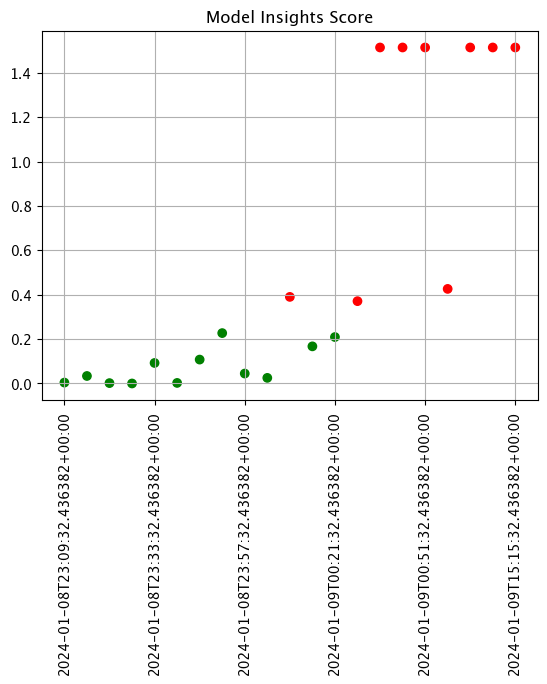

In [292]:
# assay window from numpy

# assay window from dates

assay_window_end = datetime.datetime.now()

assay_builder_from_dates = assay_builder_from_dates.add_run_until(assay_window_end)

# show just the ops


# View 1 minute intervals
# just combined
(assay_builder_from_dates
    .window_builder()
    .add_width(minutes=6)
    .add_interval(minutes=6)
    .add_start(assay_window_start)
    .add_location_filter([ops_partition, edge_name])
)

assay_config = assay_builder_from_dates.build()
assay_results = assay_config.interactive_run()

print(f"Generated {len(assay_results)} analyses")
assay_results.chart_scores()


In [293]:
display(assay_results.to_dataframe().loc[:, ["score", "start", "alert_threshold", "status"]])

,score,start,alert_threshold,status
0,0.004046,2024-01-08T23:09:32.436382+00:00,0.25,Ok
1,0.033789,2024-01-08T23:15:32.436382+00:00,0.25,Ok
2,0.001706,2024-01-08T23:21:32.436382+00:00,0.25,Ok
3,0.000000,2024-01-08T23:27:32.436382+00:00,0.25,Ok
4,0.092420,2024-01-08T23:33:32.436382+00:00,0.25,Ok
5,0.002509,2024-01-08T23:39:32.436382+00:00,0.25,Ok
6,0.107682,2024-01-08T23:45:32.436382+00:00,0.25,Ok
7,0.227043,2024-01-08T23:51:32.436382+00:00,0.25,Ok
8,0.044762,2024-01-08T23:57:32.436382+00:00,0.25,Ok
9,0.025240,2024-01-09T00:03:32.436382+00:00,0.25,Ok


In [296]:
# create baseline from numpy

assay_name_from_dates = "average confidence drift detection ops only"
step_name = "resnet-with-intensity"
assay_builder_from_dates = wl.build_assay(assay_name_from_dates, 
                               pipeline, 
                               step_name, 
                               iopath="output avg_confidence 0", 
                               baseline_start=baseline_start,
                               baseline_end=baseline_end)

Generated 15 analyses


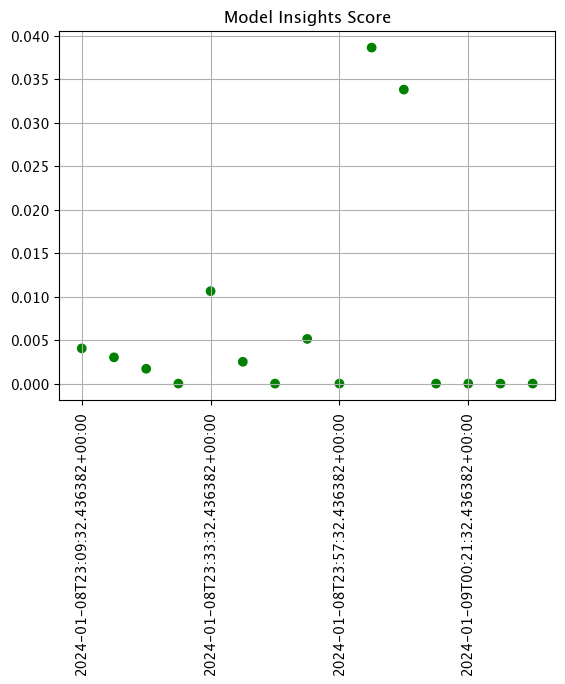

In [297]:
# assay window from numpy

# assay window from dates

assay_window_end = datetime.datetime.now()

assay_builder_from_dates = assay_builder_from_dates.add_run_until(assay_window_end)

# show just the ops


# View 1 minute intervals
# just combined
(assay_builder_from_dates
    .window_builder()
    .add_width(minutes=6)
    .add_interval(minutes=6)
    .add_start(assay_window_start)
    .add_location_filter([ops_partition])
)

assay_config = assay_builder_from_dates.build()
assay_results = assay_config.interactive_run()

print(f"Generated {len(assay_results)} analyses")
assay_results.chart_scores()


In [284]:
display(assay_results.to_dataframe().loc[:, ["score", "start", "alert_threshold", "status"]])

,score,start,alert_threshold,status
0,0.004046,2024-01-08T23:09:32.436382+00:00,0.25,Ok
1,0.003020,2024-01-08T23:15:32.436382+00:00,0.25,Ok
2,0.001706,2024-01-08T23:21:32.436382+00:00,0.25,Ok
3,0.000000,2024-01-08T23:27:32.436382+00:00,0.25,Ok
4,0.010626,2024-01-08T23:33:32.436382+00:00,0.25,Ok
5,0.002509,2024-01-08T23:39:32.436382+00:00,0.25,Ok
6,0.000000,2024-01-08T23:45:32.436382+00:00,0.25,Ok
7,0.005138,2024-01-08T23:51:32.436382+00:00,0.25,Ok
8,0.000000,2024-01-08T23:57:32.436382+00:00,0.25,Ok
9,0.038616,2024-01-09T00:03:32.436382+00:00,0.25,Ok


Generated 16 analyses


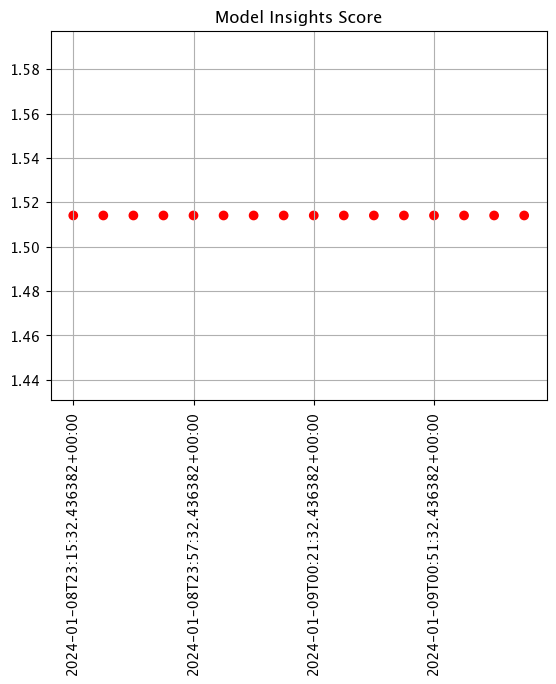

In [285]:
# assay window from numpy

# assay window from dates

assay_window_end = datetime.datetime.now()

assay_builder_from_dates = assay_builder_from_dates.add_run_until(assay_window_end)

# show just the ops


# View 1 minute intervals
# just combined
(assay_builder_from_dates
    .window_builder()
    .add_width(minutes=6)
    .add_interval(minutes=6)
    .add_start(assay_window_start)
    .add_location_filter([edge_name])
)

assay_config = assay_builder_from_dates.build()
assay_results = assay_config.interactive_run()

print(f"Generated {len(assay_results)} analyses")
assay_results.chart_scores()


In [286]:
display(assay_results.to_dataframe().loc[:, ["score", "start", "alert_threshold", "status"]])

,score,start,alert_threshold,status
0,1.514058,2024-01-08T23:15:32.436382+00:00,0.25,Alert
1,1.514058,2024-01-08T23:33:32.436382+00:00,0.25,Alert
2,1.514058,2024-01-08T23:45:32.436382+00:00,0.25,Alert
3,1.514058,2024-01-08T23:51:32.436382+00:00,0.25,Alert
4,1.514058,2024-01-08T23:57:32.436382+00:00,0.25,Alert
5,1.514058,2024-01-09T00:03:32.436382+00:00,0.25,Alert
6,1.514058,2024-01-09T00:09:32.436382+00:00,0.25,Alert
7,1.514058,2024-01-09T00:15:32.436382+00:00,0.25,Alert
8,1.514058,2024-01-09T00:21:32.436382+00:00,0.25,Alert
9,1.514058,2024-01-09T00:27:32.436382+00:00,0.25,Alert


In [265]:
pipeline.export_logs(dataset=['time', 'out.avg_confidence', 'out.avg_px_intensity', 'metadata'])

In [295]:
pipeline.undeploy()

name,retail-inv-tracker-edge-obs
created,2024-01-08 18:38:42.874282+00:00
last_updated,2024-01-08 18:58:45.613989+00:00
deployed,False
arch,None
tags,
versions,"27835e9e-0f65-4e14-a094-938e3f3af220, 655dd997-120c-4fc0-a780-0b8a332c6fcb, e89a34a8-85b7-47d7-b1c2-3371c8bc73b4"
steps,resnet-with-intensity
published,False
